In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt 
import numpy as np
import time
import cv2

from PIL import Image
from torch.autograd import Variable

In [2]:
#Load data
#Using argument data
#Imput size = 224x224 because using Resnet pre-trained
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_val = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_set = datasets.ImageFolder(root='./Animals-Dataset/train', transform=transform_train)
val_set = datasets.ImageFolder(root='./Animals-Dataset/val', transform=transform_val)

batch_size = 32

train_load = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_load = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


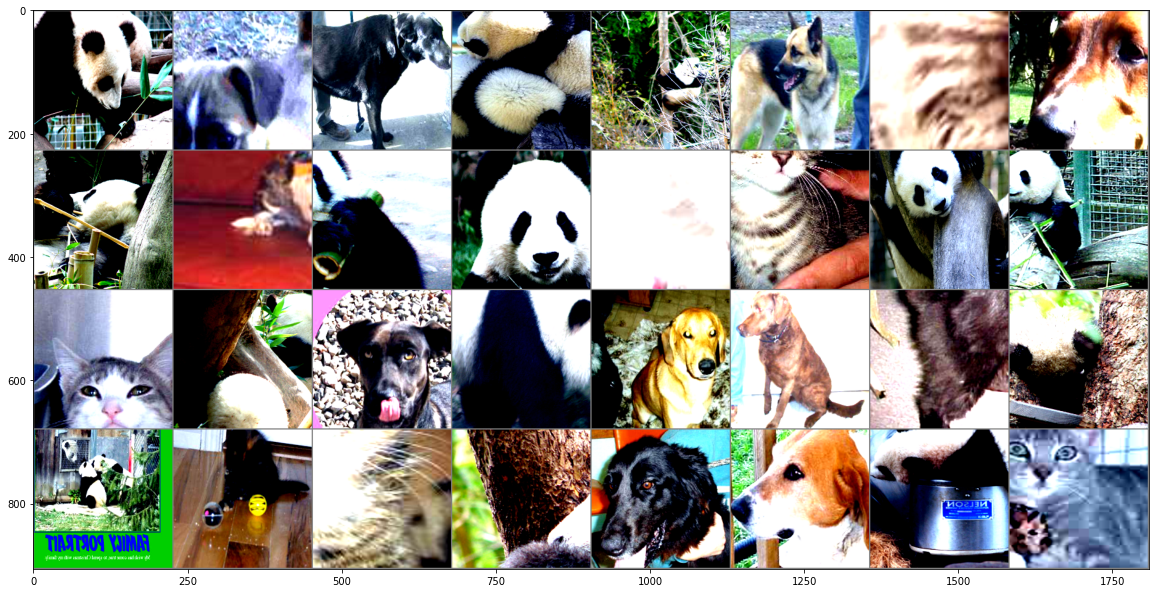

In [16]:

#Show image in a batch 
def imgshow(img):
    img = img/2 + 0.5 
    np_img = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

    
data_iter = iter(train_load)
img, labels = data_iter.next()
imgshow(torchvision.utils.make_grid(img))

In [5]:
#Set requires_grad = False for pre-trained of Resnet, no update parameters in this
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
#Define Transfer Learning net
def resnet_transfer(num_class):
    #Load Resnet18 have pre-trained
    resnet_transfer = models.resnet18(pretrained=True)
    
    #Set requires_grad = False in resnet.features
    set_parameter_requires_grad(resnet_transfer, feature_extracting=True)
    
    #Change FC layer with output = num_class
    num_ftr = resnet_transfer.fc.in_features
    resnet_transfer.fc = nn.Linear(num_ftr, num_class)

    return resnet_transfer

In [7]:
#Define 
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Def training model 
def Training_Model(model, epochs, parameters):
    #Using CrossEntropyLoss, optim SGD
    loss_f = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(parameters, lr=0.01)

    model = model.cuda()
    
    for epoch in range(epochs): 
        start = time.time()
        correct = 0
        iterations = 0
        iter_loss = 0.0
        
        model.train() #Set mode Train                  
        
        for i, (inputs, labels) in enumerate(train_load, 0):
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()  
            
            outputs = model(inputs)    
            loss = loss_f(outputs, labels)  
            iter_loss += loss.item()   
            
            loss.backward()               
            optimizer.step()                
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            iterations += 1
    

        train_loss.append(iter_loss/iterations)
        train_acc.append((100 * correct / len(train_set)))
   
        #val_training
        loss = 0.0
        correct = 0
        iterations = 0

        model.eval() #Set mode evaluation

        #No_grad on Val_set
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_load, 0):
                
                inputs = Variable(inputs)
                labels = Variable(labels)
                
                inputs = inputs.cuda()
                labels = labels.cuda()
                
                outputs = model(inputs)     
                loss = loss_f(outputs, labels) 
                loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum()
                iterations += 1

            val_loss.append(loss/iterations)
            val_acc.append((100 * correct / len(val_set)))

        stop = time.time()
        
        print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}, Time: {}s'
            .format(epoch+1, epochs, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1],stop-start))

In [8]:
#Initial CNN
CNN = resnet_transfer(num_class=3)

#Summary NN
print(CNN)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
#Training model
epochs = 10
Training_Model(model=CNN, epochs=epochs, parameters=CNN.parameters())

AssertionError: Torch not compiled with CUDA enabled

In [10]:
#Save model
# torch.save(CNN.state_dict(),'Animals_Model_Transferlearning.pth')
CNN.load_state_dict(torch.load('Animals_Model_Transferlearning.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

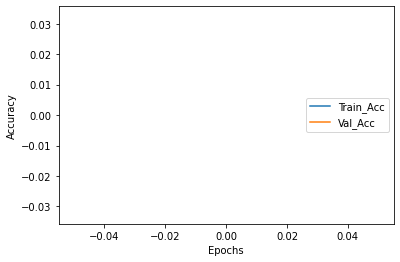

In [13]:
#Show graph
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Train_Acc')
plt.plot(val_acc, label='Val_Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.axis('equal')
plt.legend(loc=7)

In [15]:
#Label encoder
label2id = {
    0: 'Cat',
    1: 'Dog',
    2: 'PanDa'
}

#Predict func
def predict(img_name, model):
    #Load img and transform
    image = cv2.imread(img_name) 
    img = Image.fromarray(image)     
    img = transform_val(img) 
    img = img.view(1, 3, 224, 224)
    img = Variable(img)      
    
    model.eval() #set eval mode

    #To Cuda
    model = model
    img = img

    output = model(img)
   
    predicted = torch.argmax(output)
    p = label2id[predicted.item()]
    
    #Show origin img and predict
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

    return  p

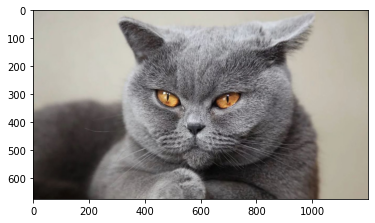

Predict:  Cat


In [11]:
print('Predict: ', predict('cat_test2.jpg', CNN))

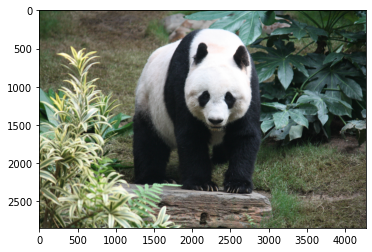

Predict:  PanDa


In [12]:
print('Predict: ', predict('panda_test.jpg', CNN))

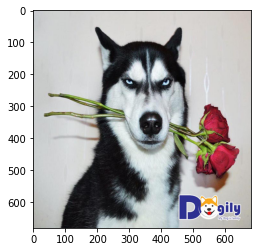

Predict:  Dog


In [13]:
print('Predict: ', predict('dog_test1.jpg', CNN))